Pre-Processing and Training Data

Import - Libraries: will help to use the modules that contain functions, and methods

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Time series libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
# SARIMA (Seasonal ARIMA) is in the statsmodels library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For the machine learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Load and Preprocess the Data
Here we load the data, convert the "DATE OCC" column to datetime, drop any problematic rows, and set it as the index.

In [2]:
# Load the CSV file
df = pd.read_csv("cleaned_data.csv")

# Display the first few rows to verify the data structure
print(df.head())

# Convert the "DATE OCC" column to datetime (ignoring any conversion errors)
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['DATE OCC'])

# Set the "DATE OCC" column as the index and sort the data by date
df.set_index('DATE OCC', inplace=True)
df.sort_index(inplace=True)

# Quick info check
df.info()


    Date Rptd    DATE OCC  TIME OCC  Vict Age  AREA   AREA NAME  Rpt Dist No  \
0  2020-03-01  2020-03-01      2130         0     7    Wilshire          784   
1  2020-02-09  2020-02-08      1800        47     1     Central          182   
2  2020-11-11  2020-11-04      1700        19     3   Southwest          356   
3  2023-05-10  2020-03-10      2037        19     9    Van Nuys          964   
4  2020-09-09  2020-09-09       630         0     4  Hollenbeck          413   

   Part 1-2                                   Premis Desc   Status Desc  \
0         1                                        STREET  Adult Arrest   
1         1             BUS STOP/LAYOVER (ALSO QUERY 124)   Invest Cont   
2         1  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   Invest Cont   
3         1                                CLOTHING STORE   Invest Cont   
4         1                                        STREET   Invest Cont   

                                   LOCATION  
0   1900 S  LONGWOOD  

Identify the Target Feature
We create our time series target by aggregating the number of crimes per month.


In [3]:
# Aggregate the data by month: count the number of crimes in each month
monthly_counts = df.resample('M').size()

# Display the first few aggregated values
print(monthly_counts.head())


DATE OCC
2020-01-31    18464
2020-02-29    17186
2020-03-31    16108
2020-04-30    15611
2020-05-31    17037
Freq: M, dtype: int64


Visualize the Monthly Crime Counts
A simple plot helps visualize the trend in crime counts over time.

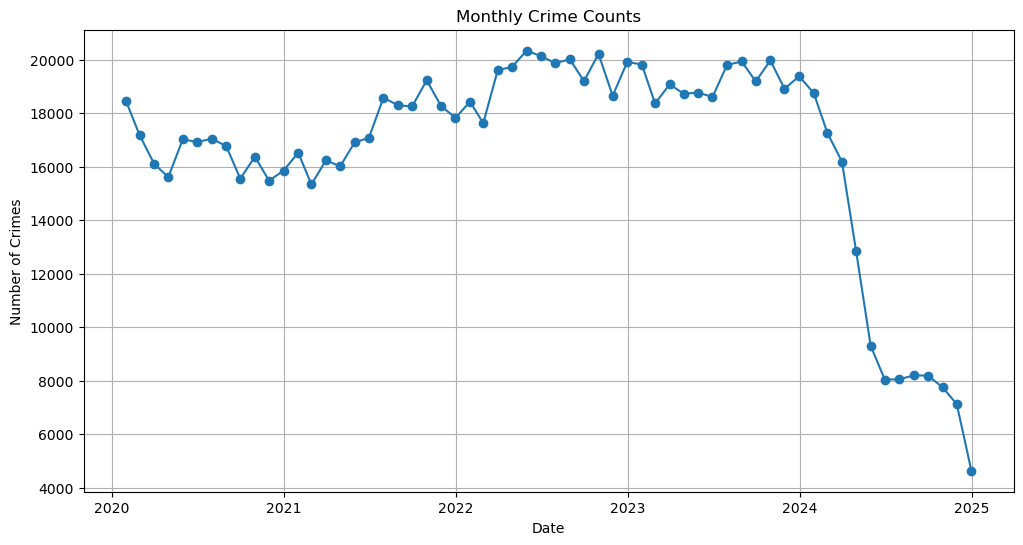

In [4]:
plt.figure(figsize=(12,6))
plt.plot(monthly_counts.index, monthly_counts, marker='o', linestyle='-')
plt.title("Monthly Crime Counts")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.grid(True)
plt.show()


Check Stationarity Using the ADF Test
Before applying ARIMA, we check if the time series is stationary.

In [5]:
# Perform the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(monthly_counts)
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))

if adf_result[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary. Consider differencing the data.")


ADF Statistic: -0.9788
p-value: 0.7609
The time series is likely non-stationary. Consider differencing the data.


ARIMA Modeling and Forecasting
For simplicity, we fit an ARIMA(1,1,1) model. (For a deeper dive, you could explore multiple orders and choose one based on AIC/BIC.)

In [6]:
# Fit an ARIMA(1,1,1) model to the monthly crime counts
model = sm.tsa.ARIMA(monthly_counts, order=(1, 1, 1))
model_fit = model.fit()

# Display the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -495.971
Date:                Wed, 12 Feb 2025   AIC                            997.943
Time:                        13:47:21   BIC                           1004.176
Sample:                    01-31-2020   HQIC                          1000.376
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9216      0.285      3.235      0.001       0.363       1.480
ma.L1         -0.8939      0.311     -2.875      0.004      -1.503      -0.284
sigma2      1.157e+06   2.01e+05      5.759      0.0

Now, forecast the next 6 months:

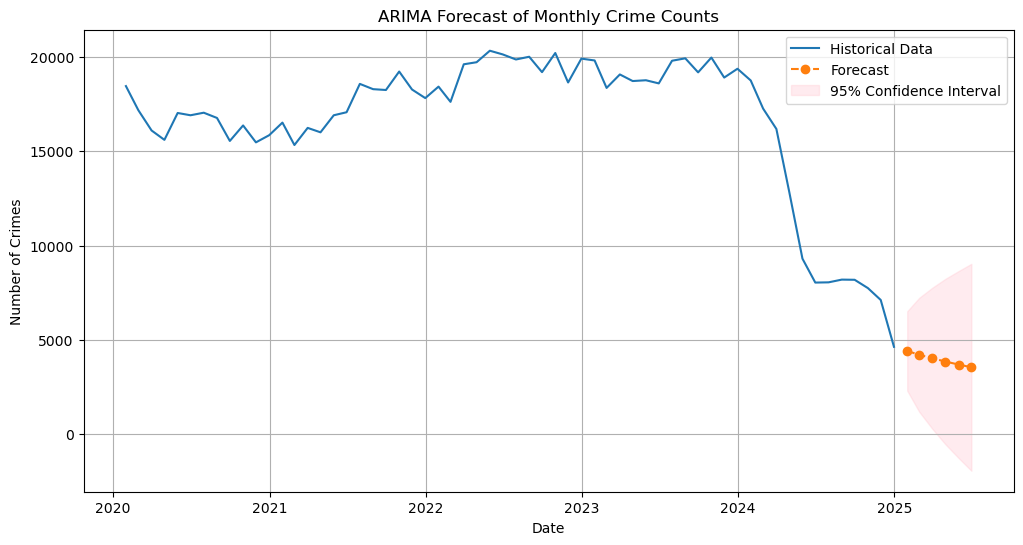

In [7]:
# Forecast the next 6 months
forecast_steps = 6
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Create a date index for the forecast period (next 6 months)
forecast_index = pd.date_range(start=monthly_counts.index[-1] + pd.offsets.MonthEnd(1), 
                               periods=forecast_steps, freq='M')

# Plot historical data and the forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_counts.index, monthly_counts, label='Historical Data')
plt.plot(forecast_index, forecast_mean, label='Forecast', marker='o', linestyle='--')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("ARIMA Forecast of Monthly Crime Counts")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.grid(True)
plt.show()


Just like ARIMA, we can do a time-based split. For example, we can use the first 80% of the data for training and the remaining 20% for testing.

In [8]:
data_length = len(monthly_counts)
split_index = int(0.8 * data_length)

train = monthly_counts.iloc[:split_index]
test = monthly_counts.iloc[split_index:]


Fit a SARIMA Model
We choose an example set of parameters, say (p, d, q) = (1, 1, 1) and (P, D, Q, m) = (1, 1, 1, 12) if we suspect a yearly seasonality (m = 12 for monthly data).

Note: If your data suggests a different seasonal period (e.g., weekly data might have m=52 for a year), adjust accordingly. You can systematically search over possible parameters if needed.

In [9]:
# Initialize a SARIMAX model with both non-seasonal and seasonal parameters
sarima_model = SARIMAX(
    train, 
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, m)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -158.106
Date:                            Wed, 12 Feb 2025   AIC                            326.213
Time:                                    13:47:22   BIC                            331.435
Sample:                                01-31-2020   HQIC                           327.346
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0023      0.044    -22.774      0.000      -1.089      -0.916
ma.L1          0.9994      0.538   

C:\Users\mercy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Forecast and Compare with Test Set
We forecast for the same length as our test set, then compare predictions to the actual data.


In [10]:
# Forecast as many steps as in the test set
n_test = len(test)
forecast_obj = sarima_fit.get_forecast(steps=n_test)

# Extract forecast values
forecast_values = forecast_obj.predicted_mean

# Optionally extract confidence intervals
conf_int = forecast_obj.conf_int()

# Create a combined series of the forecast so we can plot it with test
forecast_index = test.index  # aligns forecast with the correct dates
forecast_series = pd.Series(forecast_values, index=forecast_index)


Plot the Results
Compare predicted vs actual on the test set:

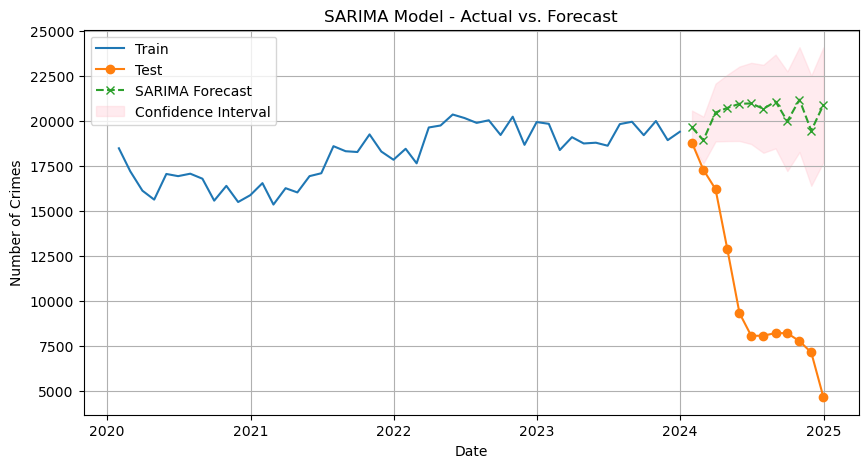

In [11]:
plt.figure(figsize=(10,5))

# Plot train data
plt.plot(train.index, train, label='Train')

# Plot test data
plt.plot(test.index, test, label='Test', marker='o')

# Plot forecast
plt.plot(forecast_series.index, forecast_series, label='SARIMA Forecast', marker='x', linestyle='--')

# Optional: Plot confidence intervals
plt.fill_between(
    forecast_index,
    conf_int.iloc[:,0],   # lower bound
    conf_int.iloc[:,1],   # upper bound
    color='pink', alpha=0.3, label='Confidence Interval'
)

plt.title("SARIMA Model - Actual vs. Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.grid(True)
plt.show()


Evaluate the Forecast
We can compute Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or Mean Absolute Error (MAE) on the test set.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast_series)
mae = mean_absolute_error(test, forecast_series)
rmse = np.sqrt(mse)

print("SARIMA Test MSE:", mse)
print("SARIMA Test MAE:", mae)
print("SARIMA Test RMSE:", rmse)


SARIMA Test MSE: 120429341.55274373
SARIMA Test MAE: 9869.126406078538
SARIMA Test RMSE: 10974.030324030626


Tuning Your SARIMA Model
The above approach uses a fixed parameter set (1,1,1)(1,1,1,12). If the results aren’t satisfactory, you can do:

A grid search over a set of (p,d,q,P,D,Q,m) values, choosing the best by AIC or BIC.
Use something like pmdarima’s auto_arima function to automatically search for good parameters.
Example (using statsmodels manual approach for a small grid search):

In [13]:
import itertools

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
m = [12]  # monthly seasonality, usually 12

best_aic = np.inf
best_params = None
best_model = None

for (p_, d_, q_) in itertools.product(p, d, q):
    for (P_, D_, Q_) in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=(p_, d_, q_),
                seasonal_order=(P_, D_, Q_, m[0]),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted_model = model.fit(method='powell', maxiter=1000, disp=False)
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = (p_, d_, q_, P_, D_, Q_)
                best_model = fitted_model
        except:
            continue

print("Best AIC:", best_aic)
print("Best params:", best_params)


C:\Users\mercy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\mercy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\mercy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\mercy\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

Best AIC: 312.2451842810467
Best params: (1, 1, 2, 1, 1, 1)
